In [9]:
# 📁 Работа с путями
import os
from pathlib import Path

# 🧠 PyTorch и PyTorch Geometric
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool, global_max_pool, global_add_pool, BatchNorm
from torch_geometric.data import DataLoader

# 📊 Метрики
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# 📈 Визуализация
import matplotlib.pyplot as plt
import numpy as np

# 🗂️ Работа с JSON
import json

In [17]:
# 📍 Укажи путь к конфигу и весам (для Linux / WSL)
SAVE_DIR = Path("/mnt/d/projects/wind_pressure_prediction_GNN/final_model/gnn_0.01lr_16bs_128hc_3lyr_relu_bn_maxpool_adam")
CONFIG_PATH = "/mnt/d/projects/wind_pressure_prediction_GNN/final_model/gnn_0.01lr_16bs_128hc_3lyr_relu_bn_maxpool_adam/gnn_0.01lr_16bs_128hc_3lyr_relu_bn_maxpool_adam.json"
MODEL_SAVE_PATH = "/mnt/d/projects/wind_pressure_prediction_GNN/final_model/gnn_0.01lr_16bs_128hc_3lyr_relu_bn_maxpool_adam"
HOLDOUT_PATH = "/mnt/d/projects/wind_pressure_prediction_GNN/data/holdout/Graphs_holdout"
WEIGHTS_PATH = "/mnt/d/projects/wind_pressure_prediction_GNN/final_model/gnn_0.01lr_16bs_128hc_3lyr_relu_bn_maxpool_adam/best_model_over_seeds_gnn_0.01lr_16bs_128hc_3lyr_relu_bn_maxpool_adam_seed410635.pth"

In [11]:
class GCNRegressor(nn.Module):
    def __init__(
        self,
        in_channels,
        hidden_channels,
        out_channels,
        num_layers=3,
        activation_fn=nn.ReLU(),
        use_batchnorm=True,
        pooling='mean',  # 'mean', 'max', 'add'
        dropout=0.2
    ):
        super(GCNRegressor, self).__init__()

        self.activation_fn = activation_fn
        self.use_batchnorm = use_batchnorm
        self.dropout = dropout

        # 🔹 Слои GCN
        self.convs = nn.ModuleList()
        self.bns = nn.ModuleList()

        self.convs.append(GCNConv(in_channels, hidden_channels))
        if use_batchnorm:
            self.bns.append(BatchNorm(hidden_channels))

        for _ in range(num_layers - 1):
            self.convs.append(GCNConv(hidden_channels, hidden_channels))
            if use_batchnorm:
                self.bns.append(BatchNorm(hidden_channels))

        # 🔹 Пулинг
        if pooling == 'mean':
            self.pool = global_mean_pool
        elif pooling == 'max':
            self.pool = global_max_pool
        elif pooling == 'add':
            self.pool = global_add_pool
        else:
            raise ValueError(f"Unsupported pooling method: {pooling}")

        # 🔹 Финальный регрессор
        self.lin1 = nn.Linear(hidden_channels, hidden_channels)
        self.lin2 = nn.Linear(hidden_channels, out_channels)

    def forward(self, x, edge_index, batch):
        for i, conv in enumerate(self.convs):
            x = conv(x, edge_index)
            if self.use_batchnorm:
                x = self.bns[i](x)
            x = self.activation_fn(x)

        x = self.lin1(x)
        x = self.activation_fn(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.lin2(x)
        return x

In [12]:
def generate_gnn_run_id(
    run_name="gnn", lr=0.001, batch_size=32, epochs=100,
    hidden_channels=None, activation_fn=None, optimizer_name=None
):
    run_id = f"{run_name}_{lr:.0e}lr_{batch_size}bs_{epochs}ep"

    if hidden_channels is not None and not isinstance(hidden_channels, (list, tuple)):
        hidden_channels = [hidden_channels]

    if hidden_channels is not None:
        hidden_str = "-".join(map(str, hidden_channels))
        run_id += f"_{hidden_str}ch"

    if activation_fn is not None:
        run_id += f"_{activation_fn.__name__}"

    if optimizer_name is not None:
        run_id += f"_{optimizer_name}"

    return run_id

In [13]:
def evaluate_on_holdout(model, holdout_path, batch_size=32, device='cuda'):
    """
    Загружает holdout-графы, делает предсказания, возвращает метрики R2, MAE, MSE
    """
    # 1. Загрузка графов
    graphs = []
    for filename in os.listdir(holdout_path):
        if filename.endswith(".pt"):
            path = os.path.join(holdout_path, filename)
            try:
                data = torch.load(path, weights_only=False)
                graphs.append(data)
            except Exception as e:
                print(f"⚠️ Ошибка при загрузке {filename}: {e}")
    print(f"✅ Загружено {len(graphs)} holdout-графов из {holdout_path}")

    # 2. DataLoader
    loader = DataLoader(graphs, batch_size=batch_size, shuffle=False)

    # 3. Предсказания модели
    model.eval()
    model.to(device)

    y_true, y_pred = [], []

    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            preds = model(batch.x, batch.edge_index, batch.batch)
            y_true.extend(batch.y.view(-1).cpu().numpy())
            y_pred.extend(preds.view(-1).cpu().numpy())

    # 4. Метрики
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)

    print(f"\n📊 Holdout Results:\nR²: {r2:.4f} | MAE: {mae:.4f} | MSE: {mse:.4f}")
    
    return {
        "r2": r2,
        "mae": mae,
        "mse": mse,
        "y_true": y_true,
        "y_pred": y_pred
    }

In [14]:
def load_config(config_path):
    with open(config_path, "r") as f:
        config = json.load(f)
    
    print("\n📦 Загруженные гиперпараметры из конфигурации:")
    for key, value in config.items():
        print(f"   {key}: {value}")
    
    return config

In [15]:
def plot_holdout_results(y_true, y_pred, save_path=None):
    residuals = y_true - y_pred

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # 🎯 True vs Predicted
    axes[0].scatter(y_true, y_pred, alpha=0.5, color="dodgerblue", edgecolors='k', linewidths=0.3)
    axes[0].plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=2, label="Ideal")
    axes[0].set_xlabel("True")
    axes[0].set_ylabel("Predicted")
    axes[0].set_title("True vs Predicted")
    axes[0].grid(True)
    axes[0].legend()

    # 📊 Residuals Histogram
    axes[1].hist(residuals, bins=40, color='gray', edgecolor='black', alpha=0.85)
    axes[1].axvline(x=0, color='red', linestyle='--', lw=2, label="Zero Error")
    axes[1].set_xlabel("Residual")
    axes[1].set_ylabel("Frequency")
    axes[1].set_title("Residuals Histogram")
    axes[1].grid(True)
    axes[1].legend()

    plt.tight_layout()

    # 💾 Сохраняем график
    if save_path:
        plt.savefig(save_path, dpi=300)
        print(f"📈 График сохранён: {save_path}")
    
    plt.show()



📦 Загруженные гиперпараметры из конфигурации:
   hidden_channels: 128
   batch_size: 16
   num_layers: 3
   activation_fn: ReLU
   use_batchnorm: True
   pooling: max
   dropout: 0.0
   lr: 0.01
   optimizer: Adam
✅ Загружено 122 holdout-графов из /mnt/d/projects/wind_pressure_prediction_GNN/data/holdout/Graphs_holdout


/mnt/d/projects/wind_pressure_prediction_GNN/linux_wpp_GNN/lib/python3.12/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)



📊 Holdout Results:
R²: 0.9046 | MAE: 0.1044 | MSE: 0.0217

🔍 Первые 5 значений:
y_true: [-0.706556 -0.826258 -0.851681 -0.862062 -0.861479]
y_pred: [-0.6279272  -0.63779646 -0.6488195  -0.6628729  -0.6782563 ]
Разница: [-0.0786 -0.1885 -0.2029 -0.1992 -0.1832]

📈 График сохранён: /mnt/d/projects/wind_pressure_prediction_GNN/final_model/gnn_0.01lr_16bs_128hc_3lyr_relu_bn_maxpool_adam/holdout_results_plot.png


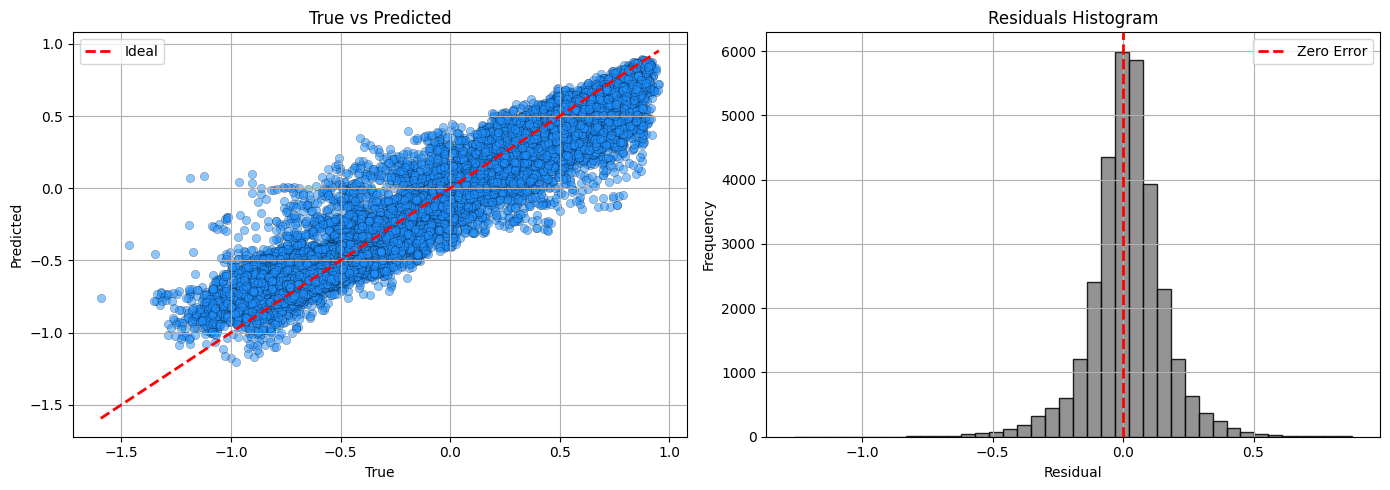

📊 Метрики сохранены в /mnt/d/projects/wind_pressure_prediction_GNN/final_model/gnn_0.01lr_16bs_128hc_3lyr_relu_bn_maxpool_adam/holdout_metrics.json


In [20]:
# 📥 Загрузка конфигурации
config = load_config(CONFIG_PATH)

# 🧠 Инициализация модели
activation_fn = getattr(torch.nn, config["activation_fn"])()
model = GCNRegressor(
    in_channels=5,  # ⚠️ замени на своё значение, если не 5
    hidden_channels=config["hidden_channels"],
    out_channels=1,
    num_layers=config["num_layers"],
    activation_fn=activation_fn,
    use_batchnorm=config["use_batchnorm"],
    pooling=config["pooling"],
    dropout=config["dropout"]
)

# 💾 Загрузка весов модели
model.load_state_dict(torch.load(WEIGHTS_PATH, map_location='cpu'))

# 🚀 Запуск инференса и расчёт метрик
results = evaluate_on_holdout(
    model=model,
    holdout_path=str(HOLDOUT_PATH),
    batch_size=config["batch_size"],
    device='cuda' if torch.cuda.is_available() else 'cpu'
)

y_true = np.array(results["y_true"])
y_pred = np.array(results["y_pred"])
print()
print("🔍 Первые 5 значений:")
print("y_true:", y_true[:5])
print("y_pred:", y_pred[:5])
print("Разница:", np.round((y_true - y_pred)[:5], 4))
print()

# 📈 Визуализация результатов
PLOT_SAVE_PATH = SAVE_DIR / "holdout_results_plot.png"
plot_holdout_results(
    y_true=np.array(results["y_true"]),
    y_pred=np.array(results["y_pred"]),
    save_path=str(PLOT_SAVE_PATH)
)

# 💾 Сохранение метрик
METRICS_SAVE_PATH = SAVE_DIR / "holdout_metrics.json"
with open(METRICS_SAVE_PATH, "w") as f:
    json.dump(
        {
            "R2": round(results["r2"], 4),
            "MAE": round(results["mae"], 4),
            "MSE": round(results["mse"], 6),
            "Total_Points": len(results["y_true"])
        },
        f,
        indent=4
    )
print(f"📊 Метрики сохранены в {METRICS_SAVE_PATH}")
